In [53]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

In [54]:
df = pd.read_csv('NSE-TATAGLOBAL.csv')
df

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
1,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
3,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
4,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55
...,...,...,...,...,...,...,...,...
2030,2010-07-27,117.60,119.50,112.00,118.80,118.65,586100,694.98
2031,2010-07-26,120.10,121.00,117.10,117.10,117.60,658440,780.01
2032,2010-07-23,121.80,121.95,120.25,120.35,120.65,281312,340.31
2033,2010-07-22,120.30,122.00,120.25,120.75,120.90,293312,355.17


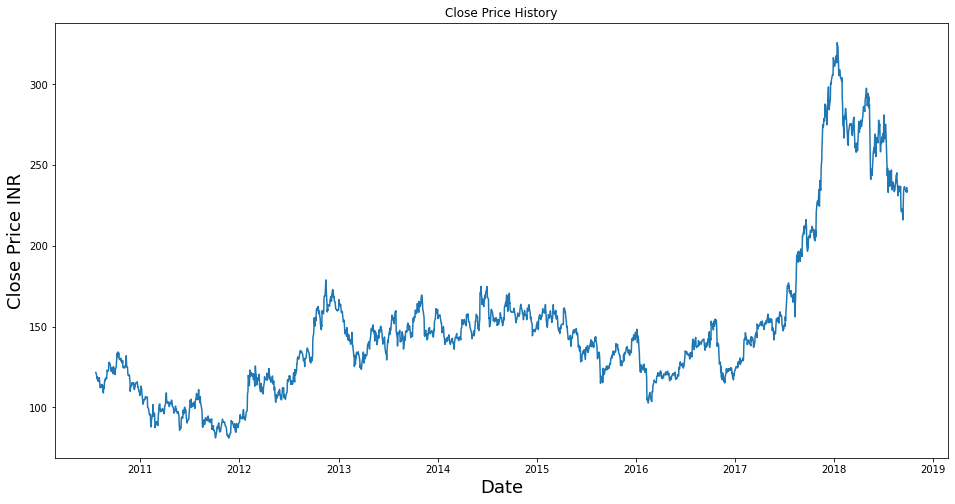

In [55]:
df["Date"] = pd.to_datetime(df.Date, format = "%Y-%m-%d")
df.index = df["Date"]
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price INR', fontsize=18)
plt.show()

In [56]:
#creating dataframe
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])


In [57]:
#Creating 'new_data' for the sorted 'Date' and 'Close' datas.
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]



In [58]:
#setting index and droping the Date head as only Price is needed to be predicted now which has been sorted already.
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

In [59]:
dataset = new_data.values


In [60]:
#splitting train and test sets
train = dataset[0:987,:]
validation = dataset[987:,:]

In [61]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])

    

In [62]:
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
    

In [63]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

In [64]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)
    

927/927 - 23s - loss: 9.7500e-04 - 23s/epoch - 25ms/step


In [68]:
#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(validation) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)
    

In [70]:
#Creating the test data.
X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

In [ ]:
#The lower the rms value, the better the prediction will be.
rms = np.sqrt(np.mean(np.power((validation - closing_price), 2)))

print(rms)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19984\1109160641.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = closing_price


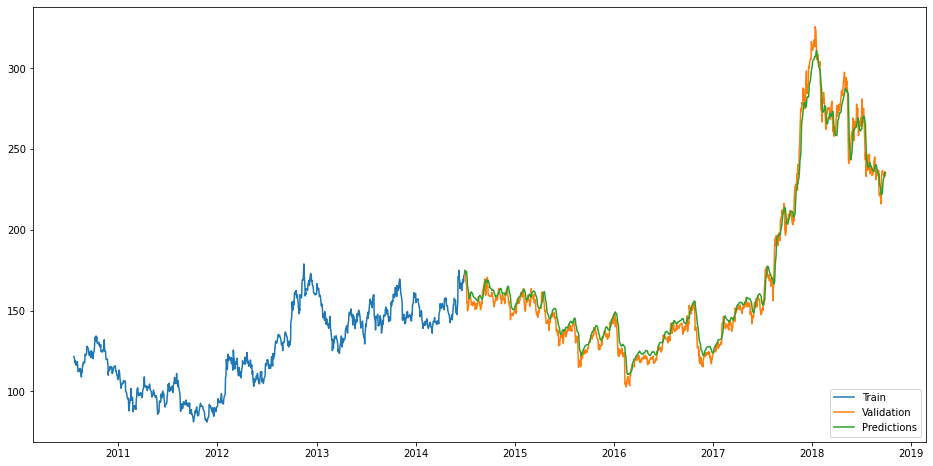

In [76]:
#plotting the data
train = new_data[:987]
validation = new_data[987:]
validation['Predictions'] = closing_price
plt.figure(figsize=(16,8))
plt.plot(train['Close'])
plt.plot(validation[['Close','Predictions']])
plt.legend(['Train', 'Validation', 'Predictions'], loc='lower right')
plt.show()
    